In [ ]:

!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-hr26cy5x
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-hr26cy5x
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.3 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

In [ ]:

import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from torchnet.dataset import TensorDatasetb
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
import torchinfo

In [ ]:


# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


# MODEL STORING/LOADING

In [ ]:
# storing model as decode and encoder

# model_state_dict = {'encoder':model.encoder.state_dict(),'decoder':model.decoder.state_dict(),'mask':model.segmentation_head.state_dict()}
# torch.save(model_state_dict,'testsave.pth')
# ckpt = torch.load('testsave.pth')
# model.encoder.load_state_dict(ckpt['encoder'])
# model.decoder.load_state_dict(ckpt['decoder'])
# model.segmentation_head.load_state_dict(ckpt['mask'])

<All keys matched successfully>

In [ ]:
# del model
# torch.cuda.empty_cache()

# Model Pretrain 256

In [ ]:
# prepare data
!unzip drive/MyDrive/dataset_0197/img.npy.zip
!unzip drive/MyDrive/dataset_0197/label.npy.zip
!unzip drive/MyDrive/dataset_0197/size.npy.zip

Archive:  drive/MyDrive/dataset_0197/img.npy.zip
  inflating: img.npy                 
Archive:  drive/MyDrive/dataset_0197/label.npy.zip
  inflating: label.npy               
Archive:  drive/MyDrive/dataset_0197/size.npy.zip
  inflating: size.npy                


In [ ]:
test_img = np.load('img.npy')
print(test_img[0].max())# 0-255, need to normalize to 0-1
test_label = np.load('label.npy')
print(test_label[0].max())
test_size = np.load('size.npy')
print(test_size.shape)

255
2
(7390, 2)


[256 170]


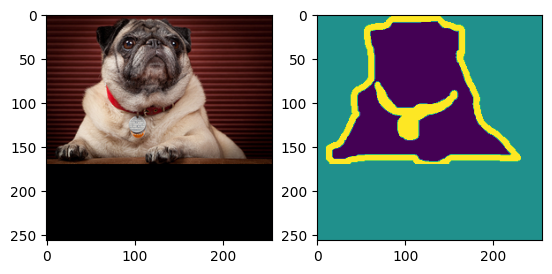

In [ ]:
_,ax = plt.subplots(nrows = 1,ncols = 2)
ax[0].imshow(test_img[1])
ax[1].imshow(test_label[1])

print(test_size[0])

In [ ]:
test_label.shape

(7390, 256, 256)

In [ ]:
# for speed generate mask here

mask = np.zeros_like(test_img[:,:,:,0])
for i in range(len(test_img)):
  mask[i,0:test_size[i,0],0:test_size[i,1]] = 1

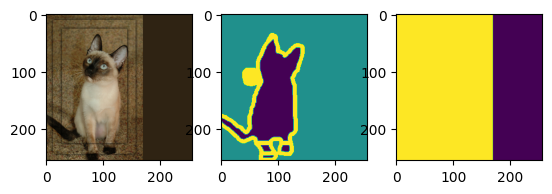

In [ ]:
_,ax = plt.subplots(nrows = 1,ncols = 3)
ax[0].imshow(test_img[3])
ax[1].imshow(test_label[3].astype(int))
ax[2].imshow(mask[0]*255.)



In [ ]:
def perturb(x, size, perportion = 0.5):
    """
    x: shape B*C*H*W image to perturb
    size: B*2 tensor of height and weight of the true image
    perportion: how many 
    
    This function perform masking/perturbing on the original images, used for pretraining, current method is rotation
    
    return:
    'torch.Tensor' with the same shape as input x
    """
    

    area = size[:,0]*size[:,1]
    B = area.shape[0]
    N = torch.randint(low = 8, high = 13,size = (1,))
    b = 10
    lower =  torch.floor((-3*b + np.sqrt(9*b**2-12*(b**2-3*perportion/N*area)))/b)
    # print(lower.shape)
    # print(lower)
    
    start_position = torch.rand(size = (B,N,2))
    start_position[:,:,0] *= (size[:,0].unsqueeze(1)-10)
    start_position[:,:,1] *= (size[:,1].unsqueeze(1)-10)
    start_position = torch.floor(start_position)
    
    
    length = torch.rand(size = (B,N))
    angles = torch.randint_like(length, high = 3)
    length = torch.round(lower[...,None] + length*b)
    # angle_list = torch.Tensor([90,180,270]).float()

    
    for i in range(B):
        for j in range(N):
            int_st1 = int(start_position[i,j,0])
            int_st2 = int(start_position[i,j,1])
            this_len = int(torch.round(length[i,j]))
            this_len = int(np.min([this_len, size[i,0]-int_st1,size[i,1]-int_st2]))
            patch = x[i,:,int_st1:(int_st1 + this_len),int_st2:(int_st2 + this_len)]
            # print(patch.shape)
            rotated = torch.rot90(patch, k = int(angles[i,j]), dims = [1,2])
            x[i,:,int_st1:(int_st1 + this_len),int_st2:(int_st2 + this_len)] = rotated
    
    

    return x

In [ ]:
# pre generate all distorted images
torch.random.manual_seed(42)
test_img = torch.Tensor(test_img).float().permute((0,3,1,2))/255.

distorted = perturb(test_img.clone(),torch.Tensor(test_size).float(),0.3)

In [ ]:
class Pretrain_set(Dataset):
  def __init__(self, img, label, size, mask, distorted):
    super().__init__()
    # normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
    # self.img = normalizer(torch.Tensor(img).float().permute((0,3,1,2))/255.)
    # self.img = torch.Tensor(img).float().permute((0,3,1,2))/255.
    self.img = img
    self.label = torch.Tensor(label).float() #wrong but not used here
    self.size = torch.Tensor(size).float()
    self.mask = torch.Tensor(mask).float()
    self.distorted = distorted
  def __len__(self):
    return len(self.img)

  def __getitem__(self,idx):
    return self.img[idx],self.label[idx],self.size[idx],self.mask[idx],self.distorted[idx]

In [ ]:
# split set into train&valid 9:1
ratio = 0.9

length = len(test_img)
indices = np.arange(length)
np.random.seed(42)
np.random.shuffle(indices)
part = int(ratio*length)


In [ ]:
pretrain_train_set = Pretrain_set(test_img[indices[:part]],test_label[indices[:part]],test_size[indices[:part]],mask[indices[:part]],distorted[indices[:part]])
pretrain_valid_set = Pretrain_set(test_img[indices[part:]],test_label[indices[part:]],test_size[indices[part:]],mask[indices[part:]],distorted[indices[part:]])

# Image Perturb

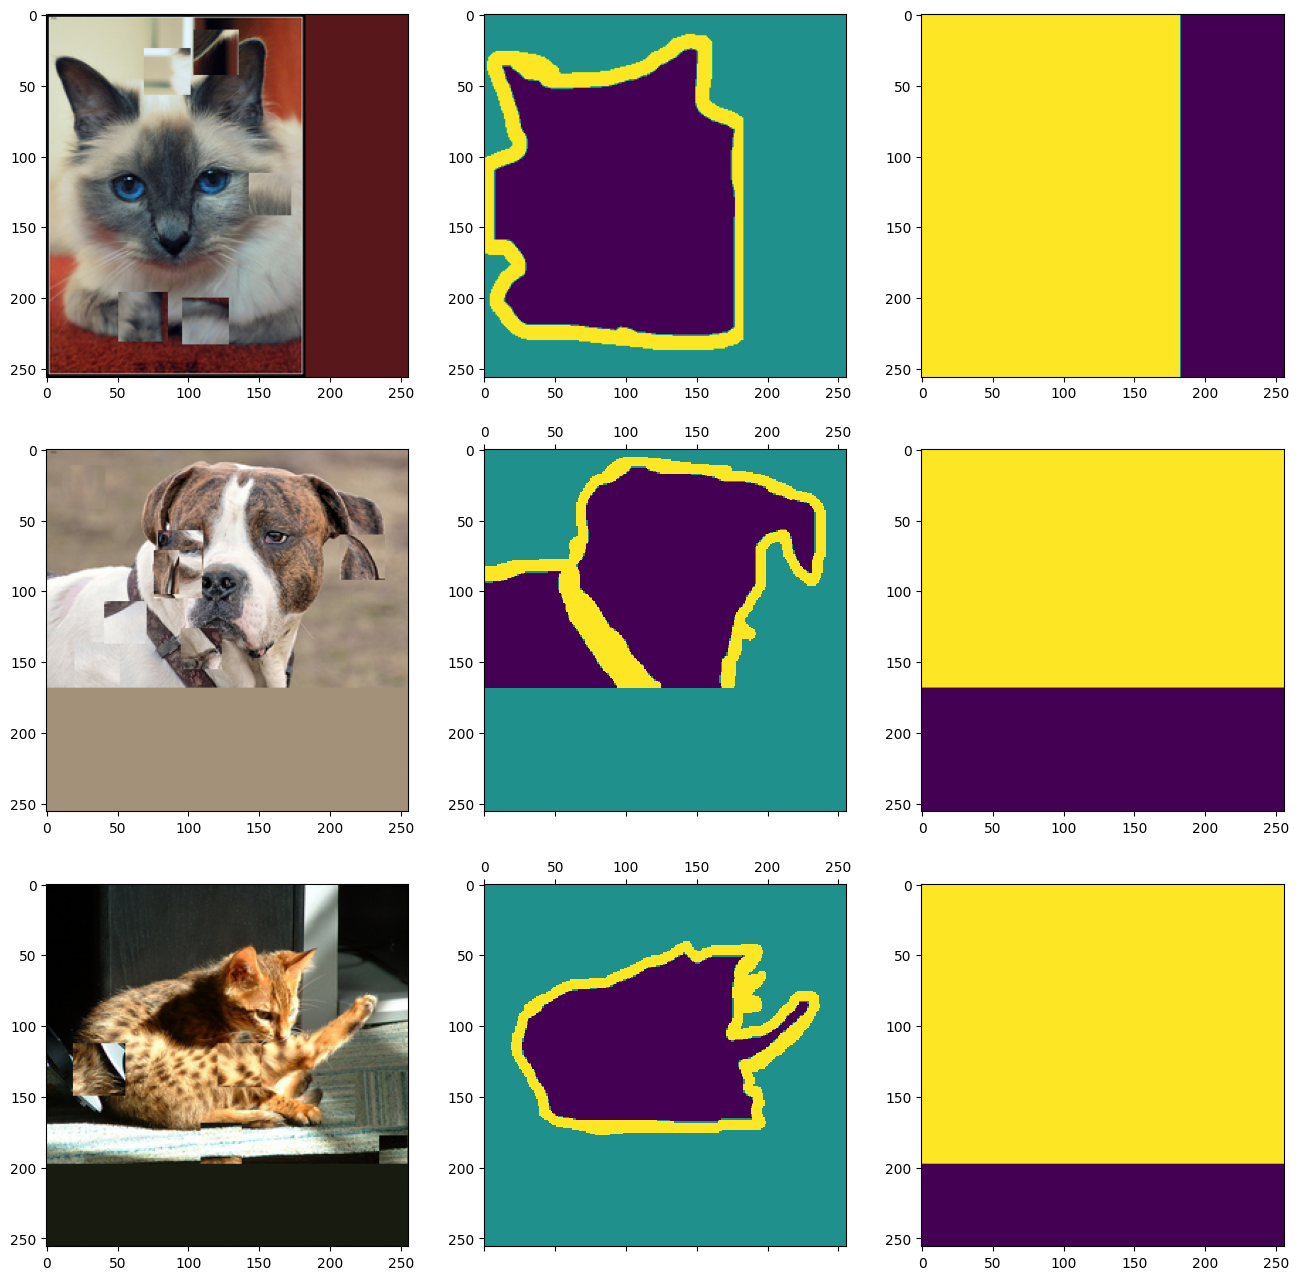

In [ ]:
# try a dataloader, and data preparing
try_batch = next(iter(DataLoader(pretrain_train_set,shuffle = True, batch_size = 3)))
perturbed = perturb(try_batch[0],try_batch[2]).permute((0,2,3,1))
#show perturbed images
fig,ax = plt.subplots(nrows = 3,ncols = 3,figsize =(16,16))

ax[0,0].imshow(perturbed[0])
ax[0,1].imshow(try_batch[1][0].int())
ax[0,2].imshow(try_batch[3][0])

ax[1,0].imshow(perturbed[1])
ax[1,1].matshow(try_batch[1][1].int())
ax[1,2].imshow(try_batch[3][1])

ax[2,0].imshow(perturbed[2])
ax[2,1].matshow(try_batch[1][2].int())
ax[2,2].imshow(try_batch[3][2])


# Training




In [ ]:
!pip install transformers
from transformers import get_linear_schedule_with_warmup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pretrain_model = smp.DeepLabV3Plus(
    encoder_name="resnet50",         # use ResNet50 as backbone
    encoder_weights="imagenet",      # use pre-trained weights from ImageNet
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    encoder_output_stride=16,        # 16 for semantic segmentation suggested in the paper for best trade-off between speech and accuracy
    decoder_atrous_rates=(6,12,18),  #dilation rates for ASPP, suggested in the paper
    decoder_channels=256,            # number of convolution filters in ASPP module (default=256)
    in_channels=4,                   # number of input channels (default=3, expects RGB images)
    upsampling=4,                    # final upsampling factor (default=8, to preserve input-output spatial shape identity) 
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for RGB image
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)

lr = 3e-4
optimizer = torch.optim.AdamW(pretrain_model.parameters(),lr = lr)
training_step = 20*500 # defined later
warm_up = 1000
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up ,num_training_steps=training_step)
batch_size = 128 # can be 128
loss_func = torch.nn.MSELoss()
save_step = 50

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
pretrain_model2 = smp.Unet(
    encoder_name="resnet34",         # use ResNet50 as backbone
    encoder_weights="imagenet",      # use pre-trained weights from ImageNet
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    in_channels=4,                   # number of input channels (default=3, expects RGB images)
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=3,                       # output 3 channels for RGB image
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)


lr = 3e-4
optimizer = torch.optim.AdamW(pretrain_model2.parameters(),lr = lr)
training_step = 10*500 # defined later
warm_up = 1000
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warm_up ,num_training_steps=training_step)
batch_size = 128 # can be 128
loss_func = torch.nn.MSELoss()
save_step = 50

In [ ]:
with torch.no_grad():
  print(pretrain_model2(torch.randn(size=(4,4,256,256))).shape)


torch.Size([4, 3, 256, 256])


In [ ]:
del pretrain_model

In [ ]:
pretrain_model2.to(device)
train_loader = DataLoader(pretrain_train_set,shuffle = True, batch_size = batch_size, num_workers = 2)
valid_loader = DataLoader(pretrain_valid_set,shuffle = True, batch_size = batch_size*2, num_workers = 2)

In [ ]:
loss_list = []
valid_list = []
step = 0

while True:

    for X in train_loader:
        pretrain_model2.train()
        img, _, size, mask, perturbed = X
        optimizer.zero_grad()
        # perturb image


        concated = torch.concat([perturbed,mask.unsqueeze(1)],dim = 1) # now Nx4x256x256

        img = img.to(device)
        concated = concated.to(device)
        mask = mask.unsqueeze(1).to(device)

        output = pretrain_model2(concated)
        loss = torch.mean(torch.square((img-output)*mask))

        print(f"step: {step+1}, loss:{loss.item():.8f}")

        # loss_mat[i,j,k,m,step] = loss.item()
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()
        step += 1

        if step % save_step == 0:

          model_state_dict = {'encoder':pretrain_model2.encoder.state_dict(),
                            'decoder':pretrain_model2.decoder.state_dict(),
                            'mask':pretrain_model2.segmentation_head.state_dict(),
                            'optimizer':optimizer.state_dict(),
                            'scheduler':scheduler.state_dict()}
          torch.save(model_state_dict,'./drive/MyDrive/dataset_0197/pretrain_ckpt_resweight_unet.pth')
        if step == training_step:
            break
    pretrain_model2.eval()
    valid_loss = []
    with torch.no_grad():
      for X in valid_loader:
          img, _, size, mask, perturbed = X

          concated = torch.concat([perturbed,mask.unsqueeze(1)],dim = 1) # now Nx4x256x256

          img = img.to(device)
          concated = concated.to(device)
          mask = mask.unsqueeze(1).to(device)

          output = pretrain_model2(concated)
          valid_loss.append(torch.mean(torch.square((img-output)*mask)).item())
    print(f"step: {step+1}, valid_loss:{np.mean(valid_loss):.8f}")
    valid_list.append(np.mean(valid_loss))
    if step == training_step:
        break

np.save('./drive/MyDrive/dataset_0197/loss_resweight_unet.npy',np.array(loss_list))


流式输出内容被截断，只能显示最后 5000 行内容。
step: 97, loss:0.18146572
step: 98, loss:0.18458948
step: 99, loss:0.16921890
step: 100, loss:0.17915677
step: 101, loss:0.15720616
step: 102, loss:0.16491032
step: 103, loss:0.16704194
step: 104, loss:0.16981247
step: 105, valid_loss:0.16916705
step: 105, loss:0.16206707
step: 106, loss:0.15532996
step: 107, loss:0.16052863
step: 108, loss:0.14716952
step: 109, loss:0.14767331
step: 110, loss:0.15362564
step: 111, loss:0.16220342
step: 112, loss:0.14080057
step: 113, loss:0.14683805
step: 114, loss:0.13941753
step: 115, loss:0.13721460
step: 116, loss:0.13294128
step: 117, loss:0.13464436
step: 118, loss:0.12989259
step: 119, loss:0.12204069
step: 120, loss:0.12599194
step: 121, loss:0.12769976
step: 122, loss:0.13323736
step: 123, loss:0.12516746
step: 124, loss:0.12504226
step: 125, loss:0.11700371
step: 126, loss:0.12244116
step: 127, loss:0.12774964
step: 128, loss:0.11819921
step: 129, loss:0.11428787
step: 130, loss:0.10931370
step: 131, loss:0.1066709

In [ ]:
def average(array,num = 20):
    array = array.reshape((-1,num))
    array = np.mean(array, axis = 1)

    return array.squeeze()

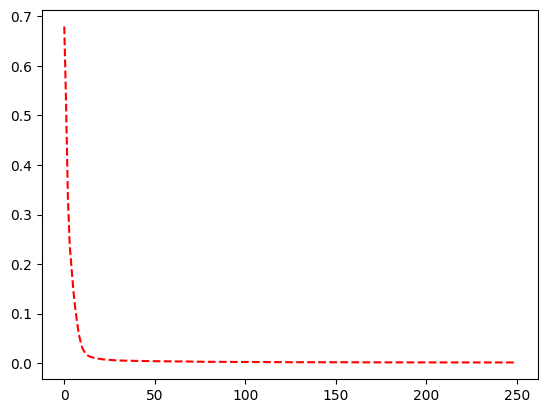

In [ ]:
plt.plot(average(np.array(loss_list)), "r--")

In [ ]:
mask.shape

torch.Size([3, 3, 256])

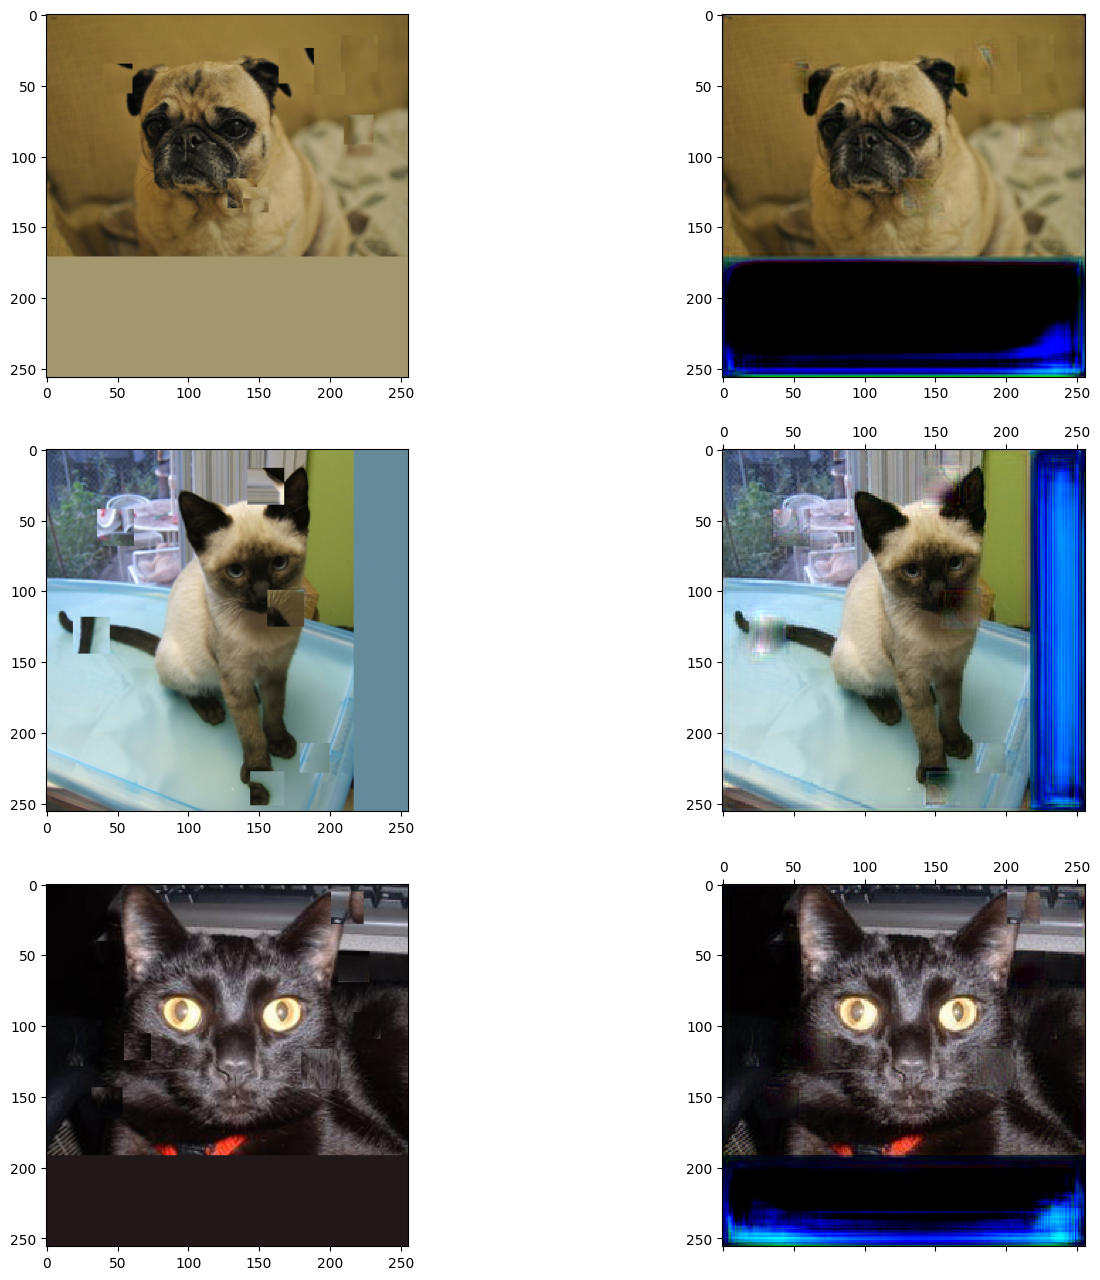

In [ ]:
try_batch = next(iter(DataLoader(pretrain_valid_set,shuffle = True, batch_size = 3)))
img, _, size, mask,perturbed = try_batch

# perturbed = perturb(img,size)
# concated = torch.concat([img,mask.unsqueeze(1)],dim = 1) # now Nx4x256x256

# img = img.to(device)
# concated = concated.to(device)
# mask = mask.unsqueeze(1).to(device)


# perturb image


concated = torch.concat([perturbed,mask.unsqueeze(1)],dim = 1) # now Nx4x256x256

img = img.to(device)
concated = concated.to(device)
mask = mask.unsqueeze(1).to(device)



with torch.no_grad():
  output = pretrain_model2(concated).detach().cpu().permute((0,2,3,1))
perturbed = perturbed.detach().cpu().permute((0,2,3,1))
img = img.detach().cpu().permute((0,2,3,1))

fig,ax = plt.subplots(nrows = 3,ncols = 2,figsize =(16,16))

ax[0,0].imshow(perturbed[0])
ax[0,1].imshow(output[0])


ax[1,0].imshow(perturbed[1])
ax[1,1].matshow(output[1])


ax[2,0].imshow(perturbed[2])
ax[2,1].matshow(output[2])



In [ ]:
!nvidia-smi

Wed Mar 29 21:30:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------